In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from BitVector import BitVector
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
import pickle
from vgg_and_resnet import *
import torch.nn.functional as F

In [6]:
def img_BGR_to_HSV(img):
    img = img.astype(np.float32)
    img_hsv = np.zeros_like(img)
    
    # Calculate key parameters through the channel axis
    M = np.max(img, axis=2)
    m = np.min(img, axis=2)
    c = M - m
    V = M
    
    # For the rows, if the max is in the first column, etc
    h0_mask = (M == img[:, :, 2]) & (c != 0) # M == R, c=/=0
    h1_mask = (M == img[:, :, 1]) & (c != 0) # M == G, c=/=0
    h2_mask = (M == img[:, :, 0]) & (c != 0) # M == B, c=/=0
    c_mask = (c == 0)                      # c == 0
    
    # Calculate H Values for each row
    # We don't just want to use the mask since c can be zero for greyscale. So we want to only compute on the masks, by checking for where to input values in first.
    with np.errstate(divide='ignore', invalid='ignore'):
        img_hsv[:, :, 0] = np.where(h0_mask, (60 * (((img[:, :, 1] - img[:, :, 0]) / c) % 6)), img_hsv[:, :, 0])
        img_hsv[:, :, 0] = np.where(h1_mask, (60 * ((img[:, :, 0] - img[:, :, 2]) / c + 2)), img_hsv[:, :, 0])
        img_hsv[:, :, 0] = np.where(h2_mask, (60 * ((img[:, :, 2] - img[:, :, 1]) / c + 4)), img_hsv[:, :, 0])
        img_hsv[:, :, 0][c_mask] = 0 # No divide by 0 errors are possible here
    # To follow opencv formatting, I will rescale the hue angles to 180deg instead of 360
    img_hsv[:, :, 0] /= 2
    
    # Fill in with correct values for the S column: (c/V)
    img_hsv[:, :, 1][V != 0] = c[V != 0]/V[V != 0] * 255
    
    # Fill in V col
    img_hsv[:,:,2] = V
    
    return np.ceil(img_hsv).astype(np.uint8)

In [7]:
class LBP():
    def __init__(self, R, P):
        self.R = R
        self.P = P
    def run_lbp(self, img_path):
        # Read image and convert it to HSV, then use the H channel for all downstream tasks.
        img_bgr = cv2.imread(img_path)
        img_hsv = img_BGR_to_HSV(img_bgr)
        img_h = img_hsv[:, :, 0]
        
        # Create padded image of size (64,64) for more feasilbe computation
        img_h_sized = cv2.resize(img_h, (62,62), interpolation=cv2.INTER_AREA)
        img_h_pad = np.pad(img_h_sized, pad_width=1, mode="constant", constant_values=0)
        
        # Initialize the histogram vector for the image: (We allow a max index of P + 1 0->9 in this case)
        lbp_histogram = np.zeros(self.P + 2)
        
        # Loop through all possible LBP centers:
        for y in range(self.R, img_h_pad.shape[0]-self.R):
            for x in range(self.R, img_h_pad.shape[1]-self.R):
                center_value = img_h_pad[y, x] # Scalar due to greyscale
                p = np.zeros(8)
                
                # Check the cardinal direction points (up,down,left,right)
                if img_h_pad[y+1][x] > center_value:
                    p[0] = 1
                if img_h_pad[y][x+1] > center_value:
                    p[2] = 1
                if img_h_pad[y-1][x] > center_value:
                    p[4] = 1
                if img_h_pad[y][x-1] > center_value:
                    p[6] = 1
                    
                # We also have to check the diagonals.
                # To calculate the pixel values at these diagonal points, we need to do pixel-interpolation
                # We also apply thresholding on the interpolated points compared to the center to determine 0/1.
                # Top right point
                p[1] = center_value * (1 - 0.707) * (1 - 0.707) + \
                        img_h_pad[y][x+1] * (1 - 0.707) * 0.707 + \
                        img_h_pad[y+1][x] * 0.707 * (1 - 0.707) + \
                        img_h_pad[y+1][x+1] * 0.707 * 0.707        
                p[1] = 1 if p[1] > center_value else 0
                
                # Bottom right point
                p[3] = center_value * (1 - 0.707) * (1 - 0.707) + \
                        img_h_pad[y][x+1] * (1 - 0.707) * 0.707 + \
                        img_h_pad[y-1][x] * 0.707 * (1 - 0.707) + \
                        img_h_pad[y-1][x+1] * 0.707 * 0.707
                p[3] = 1 if p[3] > center_value else 0
                
                # Bottom left point 
                p[5] = center_value * (1 - 0.707) * (1 - 0.707) + \
                        img_h_pad[y][x-1] * (1 - 0.707) * 0.707 + \
                        img_h_pad[y-1][x] * 0.707 * (1 - 0.707) + \
                        img_h_pad[y-1][x-1] * 0.707 * 0.707           
                p[5] = 1 if p[5] > center_value else 0
                
                # Top left point
                p[7] = center_value * (1 - 0.707) * (1 - 0.707) + \
                        img_h_pad[y][x-1] * (1 - 0.707) * 0.707 + \
                        img_h_pad[y+1][x] * 0.707 * (1 - 0.707) + \
                        img_h_pad[y+1][x-1] * 0.707 * 0.707
                p[7] = 1 if p[7] > center_value else 0
                
                # Now that we have out bitvector representation for the circle of points around the center
                # We want to find the unique min bitvector to represent the value at that point
                # We do this through circular bit-shifts to find the minimal representation:
                # This method is from Avi Kak's implementation in lecture 16
                bv = BitVector(bitlist=p)
                min_val = min([int(bv<<1) for _ in p])
                min_bv = BitVector(intVal=min_val, size=len(p))

                # Lastly, we use this min-bv value to get the final encoding for that point
                # So we create a min-int-val based integer representation of the binary pattern
                # From Avi's Notes:
                # - If the minIntVal representation involves more than two runs, encode it by the integer P + 1
                # – Else, if the minIntVal representation consists of all 0’s, represent it be the encoding 0.
                # – Else, if the minIntVal representation consists of all 1’s, represent it by the encoding P.
                # - Else: the minIntVal representation of a binary pattern has exactly two runs, that is, 
                #          a run of 0s followed by a run of 1s, represent the pattern by the number of 1’s in the second run
                num_runs = len(min_bv.runs())
                
                encoding = None
                # Mix of 1s and 0s
                if num_runs > 2:
                    encoding = self.P + 1
                # All 0s (8 of them)
                elif min_bv.int_val() == 0 and num_runs == 1:
                    encoding = self.P
                # 8 1s
                elif min_bv.int_val() == 255 and num_runs == 1:
                    encoding = self.P
                # Number of 1s in the second pattern if it is a run of all 0s then 1s
                else:
                    encoding = len(min_bv.runs()[1])
                lbp_histogram[encoding] += 1
        return lbp_histogram

In [8]:
class MySVM():
    def __init__(self):
        self.classifier = SVC(decision_function_shape="ovr")
        
    def fit(self, features, labels):
        # Train the classifier on the train data/labels
        self.classifier.fit(features, labels)
        
    def predict(self, features):
        # Predict the labels for the tes data
        return self.classifier.predict(features)
        
    def fit_predict(self, features, labels):
        # Fit and predict on the same data
        self.classifier.fit(features, labels)
        return self.classifier.predict(features)
        
    def score(self, predicted_labels, true_labels):
        # Returns the mean accuracy using the test data and labels.
        return accuracy_score(true_labels, predicted_labels), classification_report(true_labels, predicted_labels)

In [129]:
R = 1
P = 8
image_list = os.listdir("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/training/")
lbp_hist_list = []
labels_list = []
progress_bar = tqdm(image_list, desc="Training Loop")
image_type_to_label = {"cloudy": 0, "rain": 1, "shine": 2, "sunrise": 3}

for image_name in progress_bar:
    try:
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/training/" + image_name
        image_type = re.split(r"([0-9]+)", image_name)[0]
        label = image_type_to_label[image_type]
        
        lbp_hist = LBP(R=R, P=P).run_lbp(img_path=image_path)
        lbp_hist_list.append(lbp_hist)
        
        # Fill in with image name -> index for training
        labels_list.append(label)
    except Exception as e:
        print("This image did not work: ", image_name)
    

Training Loop:  85%|████████▌ | 789/926 [08:05<01:15,  1.82it/s]

This image did not work:  rain141.jpg


Training Loop:  88%|████████▊ | 819/926 [08:23<01:05,  1.63it/s]

This image did not work:  .DS_Store


Training Loop:  97%|█████████▋| 898/926 [09:10<00:16,  1.74it/s]

This image did not work:  shine131.jpg


Training Loop: 100%|██████████| 926/926 [09:27<00:00,  1.63it/s]


In [155]:
svm = MySVM()
svm.fit(lbp_hist_list, labels_list)

In [132]:
result_dict = {"lbp_hist_list": lbp_hist_list, "labels_list": labels_list}
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Saves/lbp_hists.pkl", "wb") as file:
    pickle.dump(result_dict, file)

In [136]:
test_image_list = os.listdir("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/")
test_lbp_hist_list = []
test_labels_list = []
image_type_to_label = {"cloudy": 0, "rain": 1, "shine": 2, "sunrise": 3}
test_progress_bar = tqdm(test_image_list, desc="Testing Loop")

for image_name in test_progress_bar:
    try:
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        image_type = re.split(r"([0-9]+)", image_name)[0]
        label = image_type_to_label[image_type]
        
        lbp_hist = LBP(R=R, P=P).run_lbp(img_path=image_path)
        test_lbp_hist_list.append(lbp_hist)
    
        # Add in labels based on image name
        test_labels_list.append(label)
    except Exception as e:
        print("This image did not work: ", image_name)

Testing Loop: 100%|██████████| 200/200 [01:56<00:00,  1.71it/s]


In [138]:
test_result_dict = {"test_lbp_hist_list": test_lbp_hist_list, "test_labels_list": test_labels_list}
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Saves/test_lbp_hists.pkl", "wb") as file:
    pickle.dump(test_result_dict, file)

In [156]:
predicted_labels = svm.predict(test_lbp_hist_list)

In [157]:
accuracy, class_report = svm.score(predicted_labels, test_labels_list)

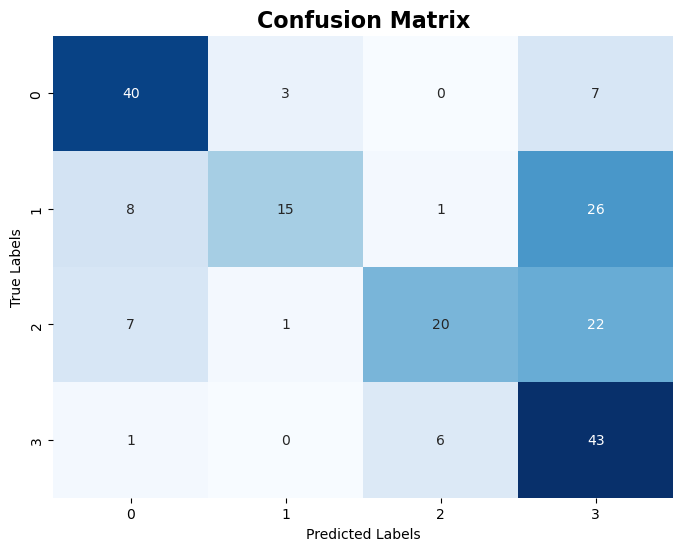

In [164]:
confusion_mat = confusion_matrix(test_labels_list, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

# Get results for LBP histograms & images success/failure

In [170]:
lbp_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/LBP_Results/"
lbp_hist_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/LBP_Hists/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"01": 0, "00": 0,
                  "11": 0, "10": 0,
                  "21": 0, "20": 0,
                  "31": 0, "30": 0}

for image_name, test_lbp_hist, test_label, pred_label in zip(test_progress_bar, test_lbp_hist_list, test_labels_list, predicted_labels):
    encoding = str(test_label)
    correct = ""
    if test_label == pred_label:
        encoding += "1"
        correct = "correct"
    else:
        encoding += "0"
        correct = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(lbp_hist_path+image_name, img_resized)
        
        # Save the histogram plot
        plt.figure(figsize=(8,6))
        plt.bar(range(len(test_lbp_hist)), test_lbp_hist, color='blue')  # Customize color as needed
        plt.tight_layout()
        # Save the plot to a file
        plt.savefig(lbp_hist_path+image_name[:-4] + "_lbp_hist_" + correct + ".png", format='png', dpi=300)
        plt.close()

# Feature Map Extraction

In [2]:
# We run this once, and save all of the feature maps for all of the images to save computation time during debugging
class FeatureMapper():
    def __init__(self):
        pass
    def get_resized_img_input(self, img_path):
        img = cv2.imread(img_path)
        # Convert images to RGB due to how RESNET and VGG expect inputs
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create padded image of size (256,256) for more feasilbe computation
        img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
        return img
        
    def get_feature_map_vgg(self, img_path):
        img = self.get_resized_img_input(img_path)
        
        # The next three lines are from the tutorial included in the instructions
        vgg = VGG19()
        vgg.load_weights('vgg_normalized.pth')
        vgg_feature = vgg(img)
        return vgg_feature
        
    def get_feature_map_resnet(self, img_path):
        img = self.get_resized_img_input(img_path)
        
        # The next three lines are from the tutorial included in the instructions
        encoder_name='resnet50'
        resnet = CustomResNet(encoder=encoder_name)
        resnet_feat_coarse, resnet_feat_fine = resnet(img)
        return resnet_feat_coarse, resnet_feat_fine

In [10]:
image_list = os.listdir("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/training/")
vgg_feature_list = []
resnet_coarse_feature_list = []
resnet_fine_feature_list = []
progress_bar = tqdm(image_list, desc="Training Loop")
image_type_to_label = {"cloudy": 0, "rain": 1, "shine": 2, "sunrise": 3}
img_names = []
labels_list = []
featureMapper = FeatureMapper()

for image_name in progress_bar:
    try:
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/training/" + image_name
        image_type = re.split(r"([0-9]+)", image_name)[0]
        label = image_type_to_label[image_type]
        
        # Get VGG Feature Map
        vgg_feature = featureMapper.get_feature_map_vgg(img_path=image_path)
        vgg_feature_list.append(vgg_feature)
        
        # Resnet Features
        resnet_feat_coarse, resnet_feat_fine = featureMapper.get_feature_map_resnet(img_path=image_path)
        resnet_coarse_feature_list.append(resnet_feat_coarse)
        resnet_fine_feature_list.append(resnet_feat_fine)
        
        # Append the image name:
        img_names.append(image_name)
        
        # Fill in with image name -> index for training
        labels_list.append(label)
    except Exception as e:
        print("This image did not work: ", image_name)
        print(e)
    

Training Loop:   0%|          | 0/926 [00:00<?, ?it/s]/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/vgg_and_resnet.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_model

This image did not work:  rain141.jpg
OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Training Loop:  88%|████████▊ | 819/926 [10:42<01:12,  1.48it/s]

This image did not work:  .DS_Store
'.DS_Store'


Training Loop:  97%|█████████▋| 898/926 [11:36<00:19,  1.47it/s]

This image did not work:  shine131.jpg
OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Training Loop: 100%|██████████| 926/926 [11:55<00:00,  1.29it/s]


In [12]:
result_dict = {"vgg_feature_list": vgg_feature_list,
               "resnet_coarse_feature_list": resnet_coarse_feature_list,
               "resnet_fine_feature_list": resnet_fine_feature_list,
               "img_names": img_names,
               "labels_list": labels_list}

In [13]:
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Saves/training_freature_mats.pkl", "wb") as file:
    pickle.dump(result_dict, file)

In [14]:
test_image_list = os.listdir("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/")
test_vgg_feature_list = []
test_resnet_coarse_feature_list = []
test_resnet_fine_feature_list = []
test_img_names = []
test_labels_list = []
image_type_to_label = {"cloudy": 0, "rain": 1, "shine": 2, "sunrise": 3}
featureMapper = FeatureMapper()
test_progress_bar = tqdm(test_image_list, desc="Testing Loop")

for image_name in test_progress_bar:
    try:
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        image_type = re.split(r"([0-9]+)", image_name)[0]
        label = image_type_to_label[image_type]
        
        # Get VGG Feature Map
        test_vgg_feature = featureMapper.get_feature_map_vgg(img_path=image_path)
        test_vgg_feature_list.append(test_vgg_feature)
        
        # Resnet Features
        test_resnet_feat_coarse, test_resnet_feat_fine = featureMapper.get_feature_map_resnet(img_path=image_path)
        test_resnet_coarse_feature_list.append(test_resnet_feat_coarse)
        test_resnet_fine_feature_list.append(test_resnet_feat_fine)
        
        # Append the image name:
        test_img_names.append(image_name)
        
        # Fill in with image name -> index for training
        test_labels_list.append(label)
    except Exception as e:
        print("This image did not work: ", image_name)
        print(e)
    

Testing Loop:   0%|          | 0/200 [00:00<?, ?it/s]/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/vgg_and_resnet.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_model 

In [15]:
test_result_dict = {"test_vgg_feature_list": test_vgg_feature_list,
               "test_resnet_coarse_feature_list": test_resnet_coarse_feature_list,
               "test_resnet_fine_feature_list": test_resnet_fine_feature_list,
               "test_img_names": test_img_names,
               "test_labels_list": test_labels_list}

In [16]:
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Saves/testing_freature_mats.pkl", "wb") as file:
    pickle.dump(result_dict, file)

# Gram Matrix Calculation:

In [55]:
def get_gram_matrix(feature_mat_list):
    f_mats = np.array(feature_mat_list)
    N, C, H, W = f_mats.shape
    fmats_flat = f_mats.reshape(N, C, H*W)
    
    # A Gram matrix is the feature_map * feature_map.T
    gram_matrix = fmats_flat @ fmats_flat.transpose(0, 2, 1)
    
    # Conver the numpy array to a pytorch tensor for biliinear interpolation in downsampling
    # I also unsqueeze in the first dimension so that pytorch treats the final two dimensions as H,W and downsamples on those
    # Otherwise, would read the it as Batch, Channel, Height and a missing width
    gram_mat_tensor = torch.from_numpy(gram_matrix).unsqueeze(0)
    
    # Lastly, we want to resize the gram matrix from 512x512 to (32,32) for easier computation
    # We do this using bilinear interpolation
    downsampled_matrix = F.interpolate(gram_mat_tensor, size=(32, 32), mode='bilinear', align_corners=False)

    return downsampled_matrix.squeeze().numpy()

In [56]:
vgg_gram_matrices = get_gram_matrix(vgg_feature_list)
resnet_coarse_gram_matrices = get_gram_matrix(resnet_coarse_feature_list)
resnet_fine_gram_matrices = get_gram_matrix(resnet_fine_feature_list)
test_vgg_gram_matrices = get_gram_matrix(test_vgg_feature_list)
test_resnet_coarse_gram_matrices = get_gram_matrix(test_resnet_coarse_feature_list)
test_resnet_fine_gram_matrices = get_gram_matrix(test_resnet_fine_feature_list)

In [60]:
# Flattening the final dimseion is required since SVM can only take in as inputs 2 dims (Batch, features)
vgg_gram_matrices = vgg_gram_matrices.reshape(vgg_gram_matrices.shape[0], -1)
resnet_coarse_gram_matrices = resnet_coarse_gram_matrices.reshape(resnet_coarse_gram_matrices.shape[0], -1)
resnet_fine_gram_matrices = resnet_fine_gram_matrices.reshape(resnet_fine_gram_matrices.shape[0], -1)
test_vgg_gram_matrices = test_vgg_gram_matrices.reshape(test_vgg_gram_matrices.shape[0], -1)
test_resnet_coarse_gram_matrices = test_resnet_coarse_gram_matrices.reshape(test_resnet_coarse_gram_matrices.shape[0], -1)
test_resnet_fine_gram_matrices = test_resnet_fine_gram_matrices.reshape(test_resnet_fine_gram_matrices.shape[0], -1)

In [73]:
# Save gram matrices to a file:
gram_matrices = {"vgg_gram_matrices": vgg_gram_matrices,
"resnet_coarse_gram_matrices": resnet_coarse_gram_matrices,
"resnet_fine_gram_matrices": resnet_fine_gram_matrices,
"test_vgg_gram_matrices": test_vgg_gram_matrices,
"test_resnet_coarse_gram_matrices": test_resnet_coarse_gram_matrices,
"test_resnet_fine_gram_matrices": test_resnet_fine_gram_matrices}
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Saves/all_gram_matrices.pkl", "wb") as file:
    pickle.dump(gram_matrices, file)

# VGG Final Results

In [70]:
# VGG SVM:
svm = MySVM()
svm.fit(vgg_gram_matrices, labels_list)
vgg_predicted_labels = svm.predict(test_vgg_gram_matrices)
vgg_accuracy, vgg_class_report = svm.score(vgg_predicted_labels, test_labels_list)
print("Accuracy: ", vgg_accuracy)
print(vgg_class_report)

Accuracy:  0.905
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.92      0.88      0.90        50
           2       0.93      0.84      0.88        50
           3       0.91      0.96      0.93        50

    accuracy                           0.91       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200



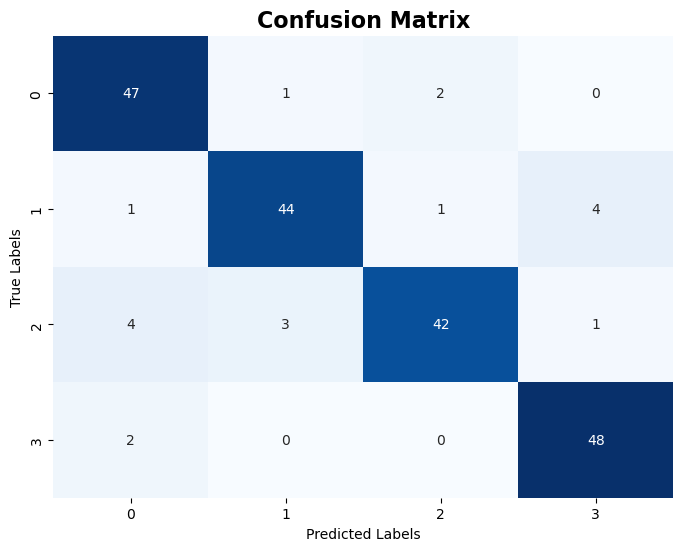

In [75]:
vgg_confusion_mat = confusion_matrix(test_labels_list, vgg_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(vgg_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [81]:
vgg_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/VGG_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"01": 0, "00": 0,
                  "11": 0, "10": 0,
                  "21": 0, "20": 0,
                  "31": 0, "30": 0}

for image_name, gram_matrix, test_label, pred_label in zip(test_progress_bar, test_vgg_gram_matrices, test_labels_list, vgg_predicted_labels):
    encoding = str(test_label)
    correct = ""
    if test_label == pred_label:
        encoding += "1"
        correct = "correct"
    else:
        encoding += "0"
        correct = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the vgg_gram_matrix back from (N,1024) -> (N, 32,32) for display
        gram_matrix = gram_matrix.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(vgg_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(gram_matrix, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(vgg_path+image_name[:-4] + "_gram_mat_" + correct + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()

# Resnet Coarse Results

In [71]:
# Resnet Coarse:
svm = MySVM()
svm.fit(resnet_coarse_gram_matrices, labels_list)
resnet_coarse_predicted_labels = svm.predict(test_resnet_coarse_gram_matrices)
resnet_coarse_accuracy, resnet_coarse_class_report = svm.score(resnet_coarse_predicted_labels, test_labels_list)
print("Accuracy: ", resnet_coarse_accuracy)
print(resnet_coarse_class_report)

Accuracy:  0.76
              precision    recall  f1-score   support

           0       0.57      0.88      0.69        50
           1       1.00      0.68      0.81        50
           2       0.88      0.60      0.71        50
           3       0.80      0.88      0.84        50

    accuracy                           0.76       200
   macro avg       0.81      0.76      0.76       200
weighted avg       0.81      0.76      0.76       200



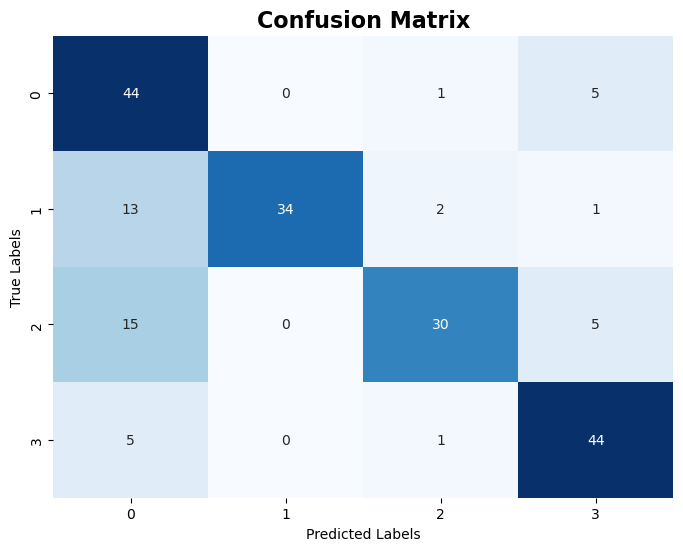

In [76]:
resnet_coarse_confusion_mat = confusion_matrix(test_labels_list, resnet_coarse_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(resnet_coarse_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [82]:
resnet_coarse_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/Resnet_Coarse_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"01": 0, "00": 0,
                  "11": 0, "10": 0,
                  "21": 0, "20": 0,
                  "31": 0, "30": 0}

for image_name, gram_matrix, test_label, pred_label in zip(test_progress_bar, test_resnet_coarse_gram_matrices, test_labels_list, resnet_coarse_predicted_labels):
    encoding = str(test_label)
    correct = ""
    if test_label == pred_label:
        encoding += "1"
        correct = "correct"
    else:
        encoding += "0"
        correct = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the vgg_gram_matrix back from (N,1024) -> (N, 32,32) for display
        gram_matrix = gram_matrix.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(resnet_coarse_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(gram_matrix, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(resnet_coarse_path+image_name[:-4] + "_gram_mat_" + correct + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()

# Resnet Fine Results:

In [72]:
# VGG SVM:
svm = MySVM()
svm.fit(resnet_fine_gram_matrices, labels_list)
resnet_fine_predicted_labels = svm.predict(test_resnet_fine_gram_matrices)
resnet_fine_accuracy, resnet_fine_class_report = svm.score(resnet_fine_predicted_labels, test_labels_list)
print("Accuracy: ", resnet_fine_accuracy)
print(resnet_fine_class_report)

Accuracy:  0.895
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        50
           1       1.00      0.94      0.97        50
           2       0.93      0.82      0.87        50
           3       0.84      0.98      0.91        50

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.90       200
weighted avg       0.90      0.90      0.90       200



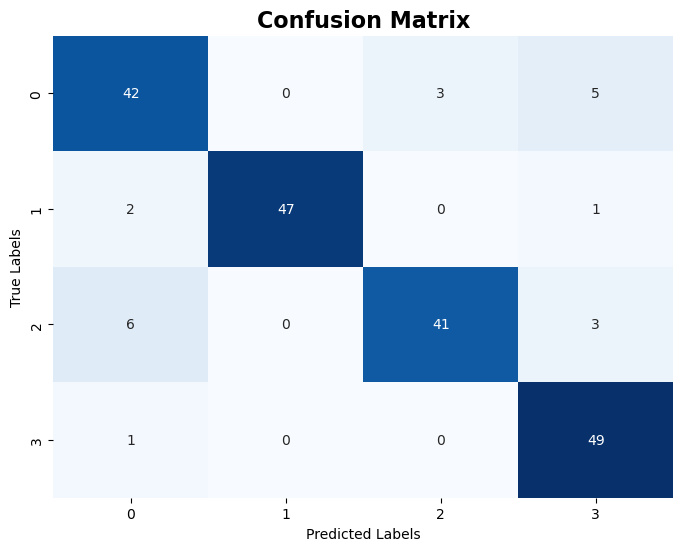

In [77]:
resnet_fine_confusion_mat = confusion_matrix(test_labels_list, resnet_fine_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(resnet_fine_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [83]:
resnet_fine_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/Resnet_Fine_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"01": 0, "00": 0,
                  "11": 0, "10": 0,
                  "21": 0, "20": 0,
                  "31": 0, "30": 0}

for image_name, gram_matrix, test_label, pred_label in zip(test_progress_bar, test_resnet_fine_gram_matrices, test_labels_list, resnet_fine_predicted_labels):
    encoding = str(test_label)
    correct = ""
    if test_label == pred_label:
        encoding += "1"
        correct = "correct"
    else:
        encoding += "0"
        correct = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the vgg_gram_matrix back from (N,1024) -> (N, 32,32) for display
        gram_matrix = gram_matrix.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(resnet_fine_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(gram_matrix, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(resnet_fine_path+image_name[:-4] + "_gram_mat_" + correct + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()

# Bonus: Channel Normalization Parameter Based Texture Descriptor

In [89]:
def get_normalization_params(feature_mat_list):
    f_mats = np.array(feature_mat_list)
    
    means = f_mats.mean(axis=(2, 3))
    variances = f_mats.std(axis=(2, 3))
    
    # I first stack the arrays together, and then reshape the final matrix to interleave the means and variances
    mu_sigma_stacked = np.stack((means, variances), axis=-1)
    channel_norm_params = mu_sigma_stacked.reshape(f_mats.shape[0], 2*f_mats.shape[1])
    
    return channel_norm_params

In [91]:
vgg_norm_params = get_normalization_params(vgg_feature_list)
resnet_coarse_norm_params = get_normalization_params(resnet_coarse_feature_list)
resnet_fine_norm_params = get_normalization_params(resnet_fine_feature_list)
test_vgg_norm_params = get_normalization_params(test_vgg_feature_list)
test_resnet_coarse_norm_params = get_normalization_params(test_resnet_coarse_feature_list)
test_resnet_fine_norm_params = get_normalization_params(test_resnet_fine_feature_list)

In [104]:
vgg_norm_params.shape

(923, 1024)

# Channel Norm Params VGG

In [92]:
# VGG SVM:
svm = MySVM()
svm.fit(vgg_norm_params, labels_list)
vgg_norm_predicted_labels = svm.predict(test_vgg_norm_params)
vgg_norm_accuracy, vgg_norm_class_report = svm.score(vgg_norm_predicted_labels, test_labels_list)
print("Accuracy: ", vgg_norm_accuracy)
print(vgg_norm_class_report)

Accuracy:  0.98
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       1.00      1.00      1.00        50
           2       0.98      0.94      0.96        50
           3       0.98      1.00      0.99        50

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



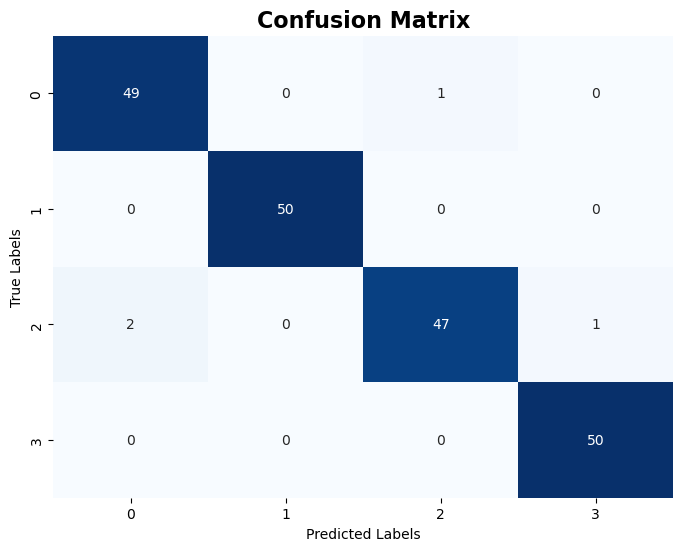

In [93]:
vgg_norm_confusion_mat = confusion_matrix(test_labels_list, vgg_norm_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(vgg_norm_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [95]:
vgg_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/VGG_Bonus_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"correct": 0, "false": 0}

for image_name, norm_params, test_label, pred_label in zip(test_progress_bar, test_vgg_norm_params, test_labels_list, vgg_norm_predicted_labels):
    correct = ""
    if test_label == pred_label:
        encoding = "correct"
    else:
        encoding = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the vgg_gram_matrix back from (N,1024) -> (N, 32,32) for display
        norm_params = norm_params.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(vgg_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(norm_params, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(vgg_path+image_name[:-4] + "_gram_mat_" + encoding + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()

# Resnet Coarse Results

In [96]:
# VGG SVM:
svm = MySVM()
svm.fit(resnet_coarse_norm_params, labels_list)
resnet_coarse_norm_predicted_labels = svm.predict(test_resnet_coarse_norm_params)
resnet_coarse_norm_accuracy, resnet_coarse_norm_class_report = svm.score(resnet_coarse_norm_predicted_labels, test_labels_list)
print("Accuracy: ", resnet_coarse_norm_accuracy)
print(resnet_coarse_norm_class_report)

Accuracy:  0.93
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        50
           1       1.00      0.94      0.97        50
           2       1.00      0.84      0.91        50
           3       0.92      0.98      0.95        50

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.93      0.93       200



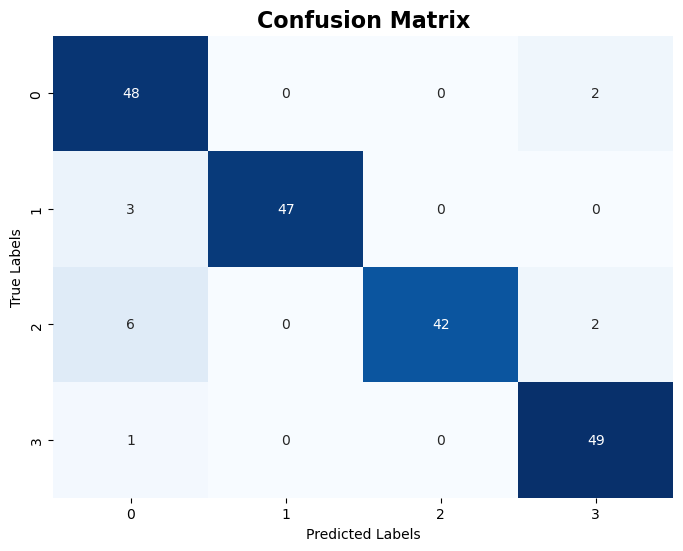

In [97]:
resnet_coarse_norm_confusion_mat = confusion_matrix(test_labels_list, resnet_coarse_norm_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(resnet_coarse_norm_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [105]:
vgg_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/Resnet_Coarse_Bonus_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"correct": 0, "false": 0}

for image_name, norm_params, test_label, pred_label in zip(test_progress_bar, test_resnet_coarse_norm_params, test_labels_list, resnet_coarse_norm_predicted_labels):
    correct = ""
    if test_label == pred_label:
        encoding = "correct"
    else:
        encoding = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the Norm Params back from (N,2048) -> (N, 32,32) for display
        # For this calculation, I need first downsample the image from 2048->1024 by taking only the even indices and then I can represent the matrix as (32,32)
        norm_params = norm_params[::2] # Extract even indices
        norm_params = norm_params.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(vgg_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(norm_params, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(vgg_path+image_name[:-4] + "_gram_mat_" + encoding + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()

# Resent Fine Results:

In [106]:
# VGG SVM:
svm = MySVM()
svm.fit(resnet_fine_norm_params, labels_list)
resnet_fine_norm_predicted_labels = svm.predict(test_resnet_fine_norm_params)
resnet_fine_norm_accuracy, resnet_fine_norm_class_report = svm.score(resnet_fine_norm_predicted_labels, test_labels_list)
print("Accuracy: ", resnet_fine_norm_accuracy)
print(resnet_fine_norm_class_report)

Accuracy:  0.915
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       1.00      0.94      0.97        50
           2       0.98      0.82      0.89        50
           3       0.88      0.98      0.92        50

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.92       200
weighted avg       0.92      0.92      0.92       200



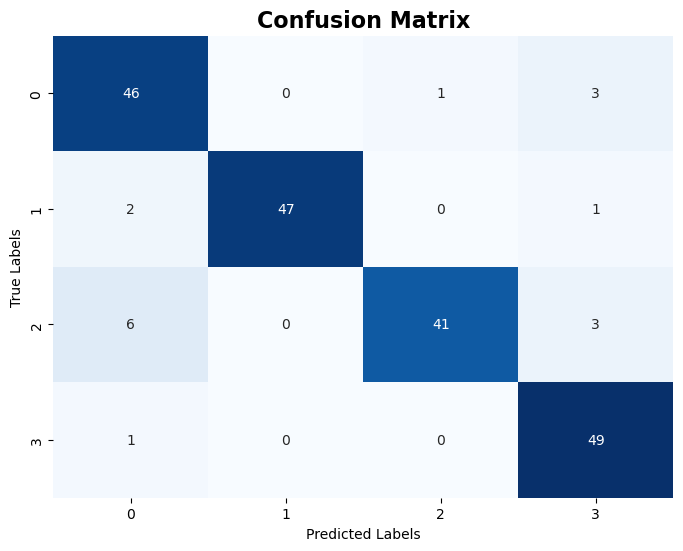

In [107]:
resnet_fine_norm_confusion_mat = confusion_matrix(test_labels_list, resnet_fine_norm_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(resnet_fine_norm_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [108]:
vgg_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/Results/Resnet_Fine_Bonus_Results/"
# I only want to save 1 positive match example and 1 negative match example for each class
# The class is therefore the first number, and the second number is for matching labels or not
results_gotten = {"correct": 0, "false": 0}

for image_name, norm_params, test_label, pred_label in zip(test_progress_bar, test_resnet_fine_norm_params, test_labels_list, resnet_fine_norm_predicted_labels):
    correct = ""
    if test_label == pred_label:
        encoding = "correct"
    else:
        encoding = "false"
    
    if results_gotten[encoding] == 0:
        # New type of result to save
        results_gotten[encoding] += 1
        
        # Convert the vgg_gram_matrix back from (N,1024) -> (N, 32,32) for display
        norm_params = norm_params.reshape(32, 32)
        
        # Save the resize testing image
        image_path = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW7/HW7-Auxilliary/data/testing/" + image_name
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(vgg_path+image_name, img_resized)
        
        # Save the gram matrix to display for results section of the report
        plt.figure(figsize=(8,6))
        
        # Use seaborn to create a heatmap
        sns.heatmap(norm_params, cmap="viridis", cbar=True)
        plt.tight_layout()
        # Save the heatmap to a file
        plt.savefig(vgg_path+image_name[:-4] + "_gram_mat_" + encoding + ".png", format='png', dpi=300, bbox_inches="tight")
        plt.close()